Q3


##Get the device information

In [ ]:
import torch
torch.cuda.get_device_name(device=None)

'Tesla T4'

#Load required libraries

In [ ]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt


Data loading and Preprocessing.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Dataset/Assignment3_dataset/Assignment3_dataset3'

from torchvision import datasets, transforms
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((64,64)),  # Resize images to a common size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Load the dataset
dataset = datasets.ImageFolder(root= path, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 109
    Root location: /content/drive/MyDrive/Dataset/Assignment3_dataset/Assignment3_dataset3
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [ ]:
print(dataset[0])

(tensor([[[0.2588, 0.2667, 0.2706,  ..., 0.6275, 0.6353, 0.5333],
         [0.2000, 0.2157, 0.2157,  ..., 0.6000, 0.4078, 0.3569],
         [0.2196, 0.2510, 0.2588,  ..., 0.4706, 0.3373, 0.3137],
         ...,
         [0.9490, 0.9490, 0.9451,  ..., 0.8549, 0.8549, 0.8510],
         [0.9412, 0.9412, 0.9333,  ..., 0.8549, 0.8510, 0.8431],
         [0.9412, 0.9373, 0.9294,  ..., 0.8549, 0.8471, 0.8431]],

        [[0.0039, 0.0039, 0.0078,  ..., 0.2275, 0.2431, 0.1451],
         [0.0039, 0.0039, 0.0078,  ..., 0.1961, 0.0588, 0.0235],
         [0.0078, 0.0078, 0.0078,  ..., 0.1020, 0.0118, 0.0039],
         ...,
         [0.6196, 0.6118, 0.5922,  ..., 0.4392, 0.4431, 0.4392],
         [0.6118, 0.5922, 0.5725,  ..., 0.4353, 0.4392, 0.4275],
         [0.6118, 0.5882, 0.5529,  ..., 0.4431, 0.4353, 0.4314]],

        [[0.0039, 0.0078, 0.0078,  ..., 0.0235, 0.0196, 0.0157],
         [0.0039, 0.0039, 0.0078,  ..., 0.0235, 0.0118, 0.0078],
         [0.0078, 0.0078, 0.0118,  ..., 0.0157, 0.0078, 0

In [ ]:
classes = dataset.classes
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

Number of Classes: 1
Class Names :
 ['car']


## Preserve only a few samples with a particular class label boat

In [ ]:
# Get indices for boat class
def get_indices(dataset, target_class=0):
    indices = [i for i in range(len(dataset.targets)) if dataset.targets[i] == target_class]
    return indices

# Get indices for the boat class
boat_indices = get_indices(dataset, target_class=0)
print('Num Train Samples with labels:', len(boat_indices))

# Split indices into training and validation
split_ratio = 0.9
split_index = int(split_ratio * len(boat_indices))
train_indices = boat_indices[:split_index]
val_indices = boat_indices[split_index:]

# Set up data loaders for training and validation
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indices))
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=torch.utils.data.sampler.SubsetRandomSampler(val_indices))


Num Train Samples with labels: 109


In [ ]:
dataIter = iter(train_loader)
imgs, labels = next(dataIter)

In [ ]:
#visualization of data on a grid
def imshow_RGB(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    imgs = imgs.cpu()
    npimgs = imgs.numpy()
    imgs[0] = imgs[0] * 0.2023 + 0.4914
    imgs[1] = imgs[1] * 0.1994 + 0.4822
    imgs[2] = imgs[2] * 0.2010 + 0.4465
    plt.figure(figsize=(8,8))
    T = torchvision.transforms.Resize((32,32))
    imgs = T(imgs)
    plt.imshow(np.transpose(npimgs, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


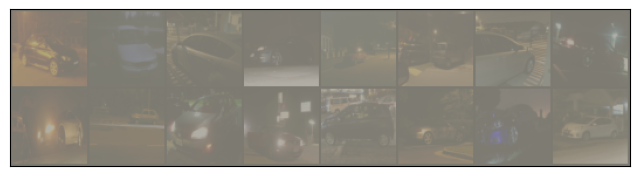

In [ ]:
imshow_RGB(imgs) #using imshow() to obtain the grid

#**DCGAN**
![Generative Adversarial Network](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Q3.a

## Create DC GAN Generator

In [ ]:
# Generator Code
nc = 3  # Number of channels in the training images. For color images this is 3
nz = 100  # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator

class DC_Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
DC_G = DC_Gen()

## Create DC GAN Discriminator

In [ ]:
#Discriminator Code
ndf = 64  # Size of feature maps in discriminator

class DC_Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
DC_D = DC_Dis()

In [ ]:
if (torch.cuda.is_available()):
    DC_D.cuda()
    DC_G.cuda()

print(DC_G)
print(DC_D)

DC_Gen(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
DC

## Set up learning rate and optimizers for generator and discriminator

In [ ]:
lr = 1e-3  #learning rate
#optimizers for both models
G_opt = opt.Adam(DC_G.parameters(), lr=lr)
D_opt = opt.Adam(DC_D.parameters(), lr=lr)

3b

## Training module for DC GAN Architecture

Epoch:0,   G_loss:13.701357977730888,    D_loss:1.469619096988546
Validation - Epoch:0,   G_loss:9.813464164733887,    D_loss:0.2847215533256531


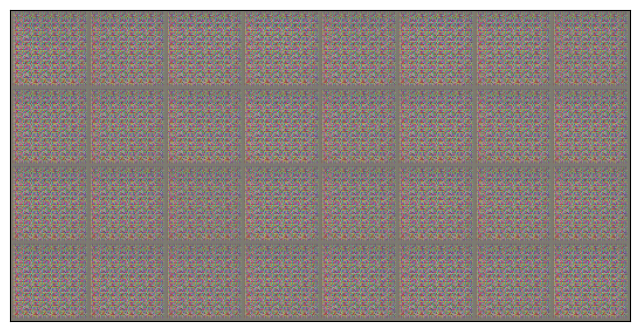

Epoch:1,   G_loss:12.182173592703682,    D_loss:1.8357686155608721
Validation - Epoch:1,   G_loss:3.5794949531555176,    D_loss:0.5212984085083008
Epoch:2,   G_loss:8.348411355699811,    D_loss:0.6667937487363815
Validation - Epoch:2,   G_loss:0.5632032155990601,    D_loss:1.0961651802062988
Epoch:3,   G_loss:7.544283594403948,    D_loss:0.8102104791573116
Validation - Epoch:3,   G_loss:2.062417984008789,    D_loss:1.57444429397583
Epoch:4,   G_loss:7.819701671600342,    D_loss:1.175392644745963
Validation - Epoch:4,   G_loss:3.4137096405029297,    D_loss:0.7485902309417725
Epoch:5,   G_loss:9.032870156424385,    D_loss:0.4154147207736969
Validation - Epoch:5,   G_loss:2.8011837005615234,    D_loss:0.5964527130126953
Epoch:6,   G_loss:10.026738711765834,    D_loss:0.4289713991539819
Validation - Epoch:6,   G_loss:1.5267492532730103,    D_loss:1.0052695274353027
Epoch:7,   G_loss:9.524042129516602,    D_loss:0.9781220299857003
Validation - Epoch:7,   G_loss:6.2514967918396,    D_loss:0.

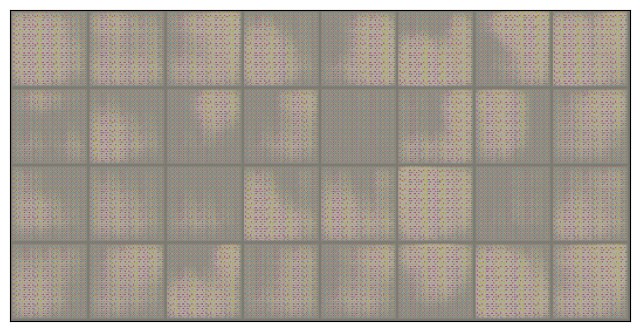

Epoch:11,   G_loss:7.299904891422817,    D_loss:0.0687357128730842
Validation - Epoch:11,   G_loss:2.639319658279419,    D_loss:0.34622859954833984
Epoch:12,   G_loss:6.389020238603864,    D_loss:0.4820248394140175
Validation - Epoch:12,   G_loss:2.8812434673309326,    D_loss:0.9538446068763733
Epoch:13,   G_loss:7.0240165165492465,    D_loss:0.26589698091681513
Validation - Epoch:13,   G_loss:5.444788455963135,    D_loss:0.3684547245502472
Epoch:14,   G_loss:5.874388422284808,    D_loss:0.03650617466441223
Validation - Epoch:14,   G_loss:4.709261417388916,    D_loss:0.2180081009864807
Epoch:15,   G_loss:6.249914850507464,    D_loss:0.10264693732772555
Validation - Epoch:15,   G_loss:3.773568630218506,    D_loss:0.22912445664405823
Epoch:16,   G_loss:8.116050447736468,    D_loss:0.14763177039899997
Validation - Epoch:16,   G_loss:7.624999523162842,    D_loss:0.5238358974456787
Epoch:17,   G_loss:8.133479935782296,    D_loss:0.06644637184217572
Validation - Epoch:17,   G_loss:5.91760015

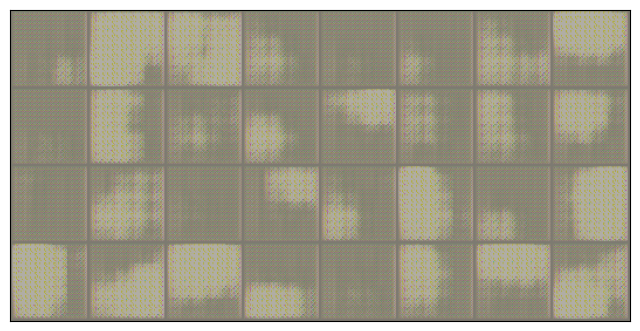

Epoch:21,   G_loss:7.460140909467425,    D_loss:0.06342062337457069
Validation - Epoch:21,   G_loss:3.9039883613586426,    D_loss:0.11421137303113937
Epoch:22,   G_loss:8.382035527910505,    D_loss:0.07092597548450742
Validation - Epoch:22,   G_loss:5.645686626434326,    D_loss:0.09490358084440231
Epoch:23,   G_loss:8.367536885397774,    D_loss:0.029883199350609044
Validation - Epoch:23,   G_loss:4.830169677734375,    D_loss:0.049140289425849915
Epoch:24,   G_loss:9.325027057102748,    D_loss:0.017790867747472867
Validation - Epoch:24,   G_loss:7.9311652183532715,    D_loss:0.012549054808914661
Epoch:25,   G_loss:8.60204907826015,    D_loss:0.008692232575932783
Validation - Epoch:25,   G_loss:4.963379383087158,    D_loss:0.0477483831346035
Epoch:26,   G_loss:7.602579253060477,    D_loss:0.04901896796322295
Validation - Epoch:26,   G_loss:6.339698791503906,    D_loss:0.26286789774894714
Epoch:27,   G_loss:9.781485285077776,    D_loss:0.02594135661742517
Validation - Epoch:27,   G_loss:5

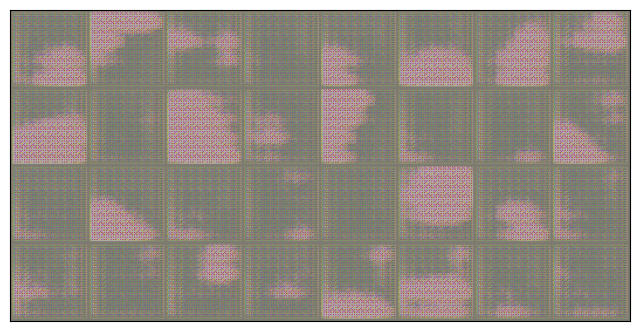

Epoch:31,   G_loss:10.471837724958148,    D_loss:0.030038566993815557
Validation - Epoch:31,   G_loss:6.2240705490112305,    D_loss:0.056584835052490234
Epoch:32,   G_loss:9.93895503452846,    D_loss:0.02103377040475607
Validation - Epoch:32,   G_loss:8.316032409667969,    D_loss:0.03847751393914223
Epoch:33,   G_loss:9.556688717433385,    D_loss:0.01776165224146098
Validation - Epoch:33,   G_loss:9.0181245803833,    D_loss:0.008393527939915657
Epoch:34,   G_loss:11.558144978114537,    D_loss:0.05150347106557872
Validation - Epoch:34,   G_loss:14.7649564743042,    D_loss:0.3068961799144745
Epoch:35,   G_loss:19.75114849635533,    D_loss:0.15284109197268542
Validation - Epoch:35,   G_loss:16.24400520324707,    D_loss:0.04204511269927025
Epoch:36,   G_loss:12.92679841177804,    D_loss:0.060217254412626584
Validation - Epoch:36,   G_loss:14.530390739440918,    D_loss:0.0022631906904280186
Epoch:37,   G_loss:13.440449578421456,    D_loss:0.0008451251487713307
Validation - Epoch:37,   G_los

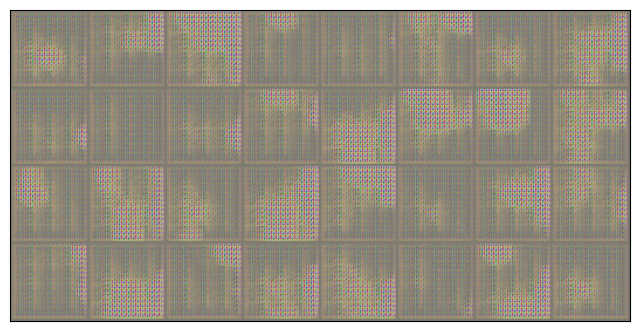

Epoch:41,   G_loss:10.285790307181221,    D_loss:0.0447878185659647
Validation - Epoch:41,   G_loss:9.34114933013916,    D_loss:0.266112357378006
Epoch:42,   G_loss:9.757063456944056,    D_loss:0.06376315919416291
Validation - Epoch:42,   G_loss:10.129289627075195,    D_loss:0.019639628008008003
Epoch:43,   G_loss:11.125145094735283,    D_loss:0.015335217716970615
Validation - Epoch:43,   G_loss:7.845689296722412,    D_loss:0.08658146858215332
Epoch:44,   G_loss:11.957386289324079,    D_loss:0.01742050687815728
Validation - Epoch:44,   G_loss:8.415770530700684,    D_loss:0.6906049847602844
Epoch:45,   G_loss:10.807076726640974,    D_loss:0.037193891694706896
Validation - Epoch:45,   G_loss:9.016703605651855,    D_loss:0.12216793745756149
Epoch:46,   G_loss:10.141502244131905,    D_loss:0.03598220899168934
Validation - Epoch:46,   G_loss:4.577300548553467,    D_loss:0.087570920586586
Epoch:47,   G_loss:18.42764391217913,    D_loss:0.07702183166319239
Validation - Epoch:47,   G_loss:18.4

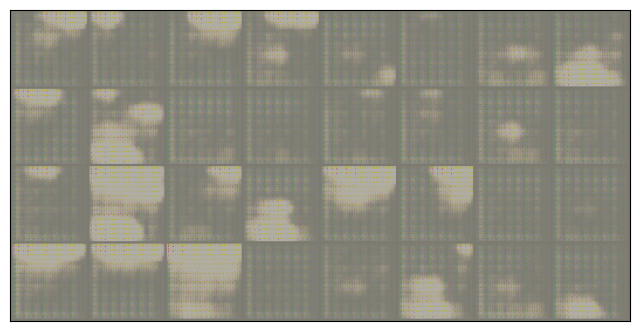

Epoch:51,   G_loss:12.657338278634208,    D_loss:0.042160484536517676
Validation - Epoch:51,   G_loss:6.510934352874756,    D_loss:0.315142422914505
Epoch:52,   G_loss:9.534690380096436,    D_loss:0.6344737389257976
Validation - Epoch:52,   G_loss:7.214733123779297,    D_loss:0.08190983533859253
Epoch:53,   G_loss:7.451932498386928,    D_loss:0.326660580933094
Validation - Epoch:53,   G_loss:7.004389762878418,    D_loss:0.3332363963127136
Epoch:54,   G_loss:7.218088660921369,    D_loss:0.5464299291904483
Validation - Epoch:54,   G_loss:2.450361728668213,    D_loss:0.3986038863658905
Epoch:55,   G_loss:9.949033737182617,    D_loss:0.08288697933728274
Validation - Epoch:55,   G_loss:13.307585716247559,    D_loss:0.15457148849964142
Epoch:56,   G_loss:12.001067570277623,    D_loss:0.011004924375031675
Validation - Epoch:56,   G_loss:6.199779510498047,    D_loss:0.026469463482499123
Epoch:57,   G_loss:9.315885952540807,    D_loss:0.031011993131999458
Validation - Epoch:57,   G_loss:9.53956

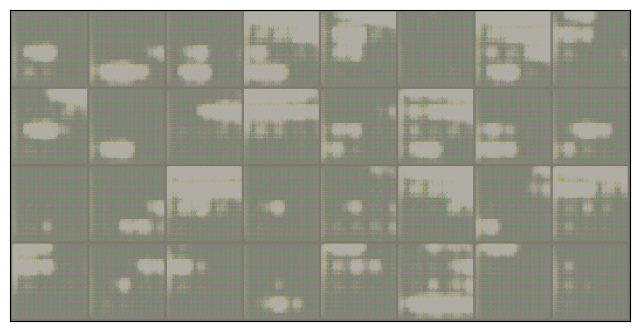

Epoch:61,   G_loss:13.036737169538226,    D_loss:0.24356071325019002
Validation - Epoch:61,   G_loss:12.668782234191895,    D_loss:0.028766365721821785
Epoch:62,   G_loss:13.243892669677734,    D_loss:0.0757570309298379
Validation - Epoch:62,   G_loss:15.464597702026367,    D_loss:0.024187106639146805
Epoch:63,   G_loss:21.003880092075892,    D_loss:0.07272685553678977
Validation - Epoch:63,   G_loss:11.602046966552734,    D_loss:0.17551088333129883
Epoch:64,   G_loss:15.184004647391182,    D_loss:0.10850362535399784
Validation - Epoch:64,   G_loss:7.203000545501709,    D_loss:0.010472678579390049
Epoch:65,   G_loss:11.636009352547783,    D_loss:0.07441718507158969
Validation - Epoch:65,   G_loss:8.922612190246582,    D_loss:0.06178746372461319
Epoch:66,   G_loss:15.407458850315638,    D_loss:0.24587644155755178
Validation - Epoch:66,   G_loss:8.356924057006836,    D_loss:0.006270809564739466
Epoch:67,   G_loss:10.237274714878627,    D_loss:0.12457065310861383
Validation - Epoch:67,   

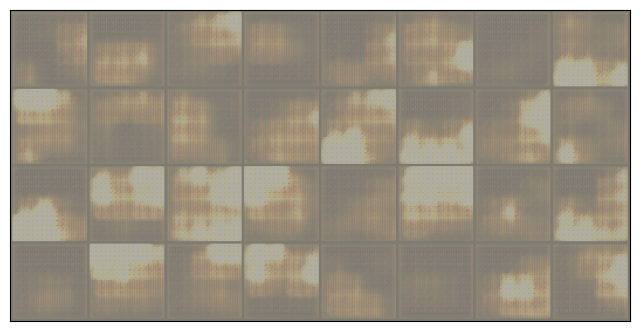

Epoch:71,   G_loss:9.927683285304479,    D_loss:0.360773502183812
Validation - Epoch:71,   G_loss:10.171722412109375,    D_loss:0.009915415197610855
Epoch:72,   G_loss:8.31389672415597,    D_loss:0.2321370736629303
Validation - Epoch:72,   G_loss:11.51335620880127,    D_loss:0.00022919649200048298
Epoch:73,   G_loss:9.249161720275879,    D_loss:0.023444888226679592
Validation - Epoch:73,   G_loss:5.801858425140381,    D_loss:0.037033092230558395
Epoch:74,   G_loss:10.722573280334473,    D_loss:0.14425205495873733
Validation - Epoch:74,   G_loss:5.343249320983887,    D_loss:0.2551126480102539
Epoch:75,   G_loss:10.913930143628802,    D_loss:0.7352198586865727
Validation - Epoch:75,   G_loss:8.907232284545898,    D_loss:0.015198391862213612
Epoch:76,   G_loss:8.68019185747419,    D_loss:0.6599646817360606
Validation - Epoch:76,   G_loss:3.1547956466674805,    D_loss:0.5343484282493591
Epoch:77,   G_loss:10.40542473111834,    D_loss:0.16596833623147436
Validation - Epoch:77,   G_loss:13.2

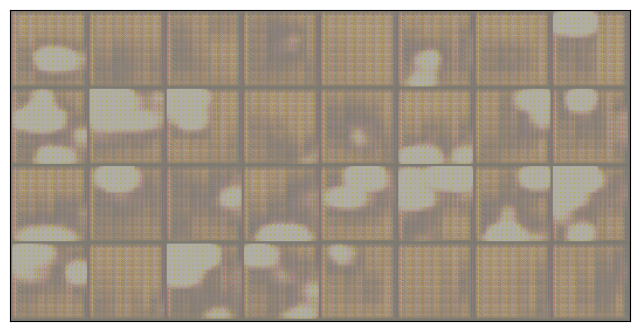

Epoch:81,   G_loss:13.430562155587333,    D_loss:0.10170075943460688
Validation - Epoch:81,   G_loss:6.154749393463135,    D_loss:0.2757048010826111
Epoch:82,   G_loss:9.861387389046806,    D_loss:0.04708056399873125
Validation - Epoch:82,   G_loss:9.662928581237793,    D_loss:0.06273861229419708
Epoch:83,   G_loss:10.530587877546038,    D_loss:0.027034708997234702
Validation - Epoch:83,   G_loss:9.937141418457031,    D_loss:0.14741899073123932
Epoch:84,   G_loss:11.768417358398438,    D_loss:0.024113408693145693
Validation - Epoch:84,   G_loss:10.682787895202637,    D_loss:0.21861079335212708
Epoch:85,   G_loss:10.970333099365234,    D_loss:0.03611967559637768
Validation - Epoch:85,   G_loss:10.288307189941406,    D_loss:0.31987857818603516
Epoch:86,   G_loss:9.982879298073906,    D_loss:0.04134303477725813
Validation - Epoch:86,   G_loss:4.815408229827881,    D_loss:0.15886777639389038
Epoch:87,   G_loss:9.790864671979632,    D_loss:0.09452090651861259
Validation - Epoch:87,   G_loss

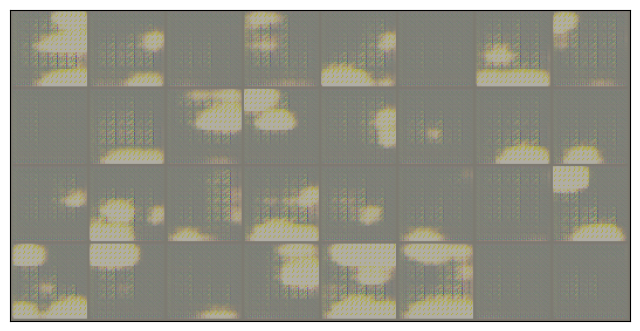

Epoch:91,   G_loss:7.972778252192906,    D_loss:0.02198638510890305
Validation - Epoch:91,   G_loss:5.564175605773926,    D_loss:0.023756515234708786
Epoch:92,   G_loss:8.120945726122175,    D_loss:0.014353024997814958
Validation - Epoch:92,   G_loss:7.799062728881836,    D_loss:0.07607768476009369
Epoch:93,   G_loss:7.796609129224505,    D_loss:0.1542143447856818
Validation - Epoch:93,   G_loss:1.7313944101333618,    D_loss:0.7204992175102234
Epoch:94,   G_loss:17.350542749677384,    D_loss:0.691960352539484
Validation - Epoch:94,   G_loss:18.42843246459961,    D_loss:0.018839944154024124
Epoch:95,   G_loss:11.310062272208077,    D_loss:0.1086070500979466
Validation - Epoch:95,   G_loss:7.79587459564209,    D_loss:0.08106479048728943
Epoch:96,   G_loss:14.225631577627999,    D_loss:0.08449543110327795
Validation - Epoch:96,   G_loss:14.221298217773438,    D_loss:0.005030714441090822
Epoch:97,   G_loss:8.918849740709577,    D_loss:0.06952656403050891
Validation - Epoch:97,   G_loss:6.3

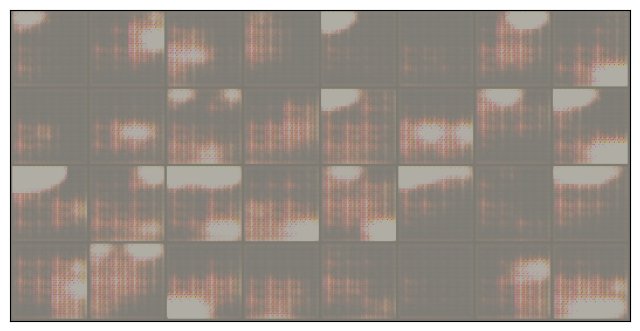

Epoch:101,   G_loss:7.381974697113037,    D_loss:0.36805647352178184
Validation - Epoch:101,   G_loss:10.235519409179688,    D_loss:1.1050183773040771
Epoch:102,   G_loss:11.234648159572057,    D_loss:0.44916437165479045
Validation - Epoch:102,   G_loss:9.293896675109863,    D_loss:0.6974949240684509
Epoch:103,   G_loss:9.808891364506312,    D_loss:0.29838310739225044
Validation - Epoch:103,   G_loss:9.907435417175293,    D_loss:0.0544506199657917
Epoch:104,   G_loss:7.992561885288784,    D_loss:0.14247366293732608
Validation - Epoch:104,   G_loss:2.268594264984131,    D_loss:0.566253662109375
Epoch:105,   G_loss:8.688350813729423,    D_loss:0.2359703979621242
Validation - Epoch:105,   G_loss:6.250735282897949,    D_loss:0.24212855100631714
Epoch:106,   G_loss:12.494625500270299,    D_loss:0.18743924098089337
Validation - Epoch:106,   G_loss:11.427824974060059,    D_loss:0.022559985518455505
Epoch:107,   G_loss:12.694493430001396,    D_loss:0.29352549304063097
Validation - Epoch:107,  

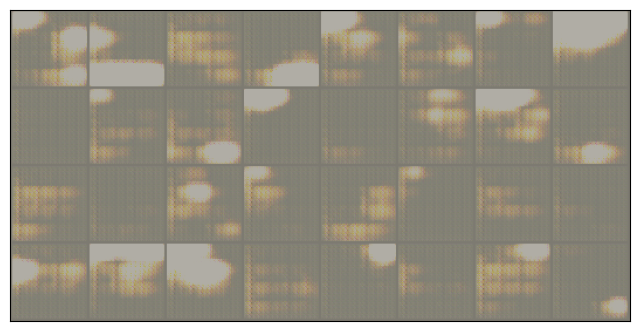

Epoch:111,   G_loss:9.55517292022705,    D_loss:0.035767886268981135
Validation - Epoch:111,   G_loss:6.828622341156006,    D_loss:0.11679444462060928
Epoch:112,   G_loss:8.231567774500165,    D_loss:0.42532375135592054
Validation - Epoch:112,   G_loss:2.1648154258728027,    D_loss:0.7629005908966064
Epoch:113,   G_loss:10.383649689810616,    D_loss:0.31228737346827984
Validation - Epoch:113,   G_loss:8.226820945739746,    D_loss:0.16389699280261993
Epoch:114,   G_loss:8.855522292000908,    D_loss:0.2166162511067731
Validation - Epoch:114,   G_loss:9.551895141601562,    D_loss:0.2793845236301422
Epoch:115,   G_loss:9.159561089106969,    D_loss:0.1401575677362936
Validation - Epoch:115,   G_loss:6.8176703453063965,    D_loss:0.03631370887160301
Epoch:116,   G_loss:11.239620889936175,    D_loss:0.089556555895667
Validation - Epoch:116,   G_loss:6.854410648345947,    D_loss:0.1031426191329956
Epoch:117,   G_loss:11.02467577798026,    D_loss:0.01635167862488223
Validation - Epoch:117,   G_

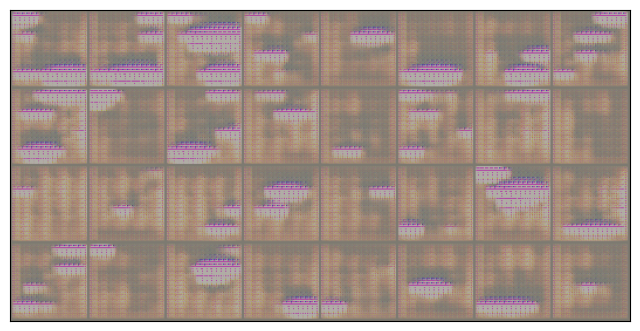

Epoch:121,   G_loss:10.140661648341588,    D_loss:0.08458083657231848
Validation - Epoch:121,   G_loss:7.293908596038818,    D_loss:0.0046287402510643005
Epoch:122,   G_loss:10.814469473702568,    D_loss:0.3983514930254647
Validation - Epoch:122,   G_loss:10.116527557373047,    D_loss:0.05096421763300896
Epoch:123,   G_loss:6.934230055127825,    D_loss:0.07321909542328545
Validation - Epoch:123,   G_loss:8.406262397766113,    D_loss:0.046004973351955414
Epoch:124,   G_loss:10.835997581481934,    D_loss:0.027394086463443403
Validation - Epoch:124,   G_loss:12.227867126464844,    D_loss:0.0022959327325224876
Epoch:125,   G_loss:9.32710531779698,    D_loss:0.04473232837127788
Validation - Epoch:125,   G_loss:6.469477653503418,    D_loss:0.07939501851797104
Epoch:126,   G_loss:9.024890967777797,    D_loss:0.058204943052260205
Validation - Epoch:126,   G_loss:8.776296615600586,    D_loss:0.020406153053045273
Epoch:127,   G_loss:10.021862030029297,    D_loss:0.07292364151882273
Validation - 

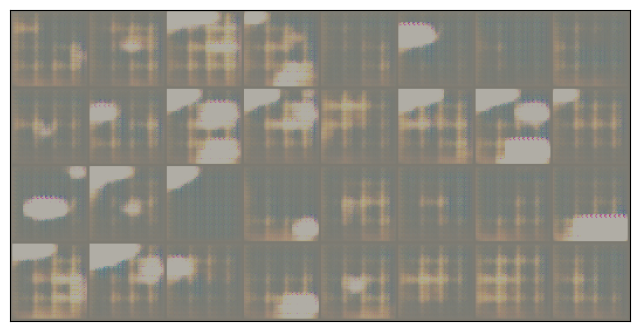

Epoch:131,   G_loss:10.419153554098946,    D_loss:0.33436029737302825
Validation - Epoch:131,   G_loss:11.482417106628418,    D_loss:0.37707164883613586
Epoch:132,   G_loss:9.287632533482142,    D_loss:0.29651063760476454
Validation - Epoch:132,   G_loss:12.084829330444336,    D_loss:0.8088322877883911
Epoch:133,   G_loss:11.243193830762591,    D_loss:0.4745237497346742
Validation - Epoch:133,   G_loss:10.854735374450684,    D_loss:0.9610695242881775
Epoch:134,   G_loss:10.014447348458427,    D_loss:0.21887322222547873
Validation - Epoch:134,   G_loss:7.9073615074157715,    D_loss:0.037871018052101135
Epoch:135,   G_loss:11.67225456237793,    D_loss:0.7320797294378281
Validation - Epoch:135,   G_loss:8.313220024108887,    D_loss:0.0392516665160656
Epoch:136,   G_loss:13.699691227504186,    D_loss:0.08521678589152414
Validation - Epoch:136,   G_loss:7.340731620788574,    D_loss:0.2718431353569031
Epoch:137,   G_loss:9.618775776454381,    D_loss:0.38569196747682455
Validation - Epoch:137

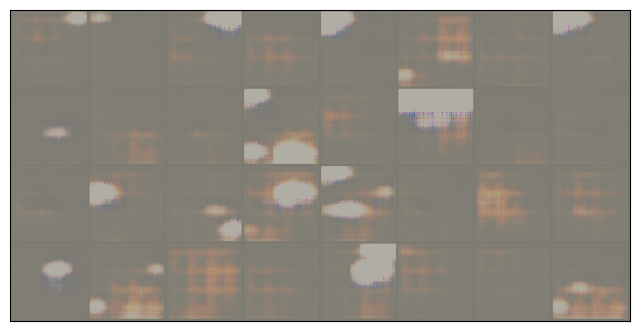

Epoch:141,   G_loss:7.943198204040527,    D_loss:0.15365593135356903
Validation - Epoch:141,   G_loss:5.041286945343018,    D_loss:0.4118277430534363
Epoch:142,   G_loss:7.067409992218018,    D_loss:0.35876542755535673
Validation - Epoch:142,   G_loss:4.6445231437683105,    D_loss:0.19610637426376343
Epoch:143,   G_loss:10.096507617405482,    D_loss:0.22247595001005852
Validation - Epoch:143,   G_loss:12.801663398742676,    D_loss:0.16493766009807587
Epoch:144,   G_loss:8.99621057510376,    D_loss:0.2859552016348711
Validation - Epoch:144,   G_loss:4.300869941711426,    D_loss:0.27729034423828125
Epoch:145,   G_loss:11.869498116629464,    D_loss:1.9984655092869485
Validation - Epoch:145,   G_loss:2.9295599460601807,    D_loss:1.0449445247650146
Epoch:146,   G_loss:10.81444263458252,    D_loss:0.5080842741070748
Validation - Epoch:146,   G_loss:14.320687294006348,    D_loss:1.3223320245742798
Epoch:147,   G_loss:9.712757110595703,    D_loss:0.4134760934061238
Validation - Epoch:147,   G

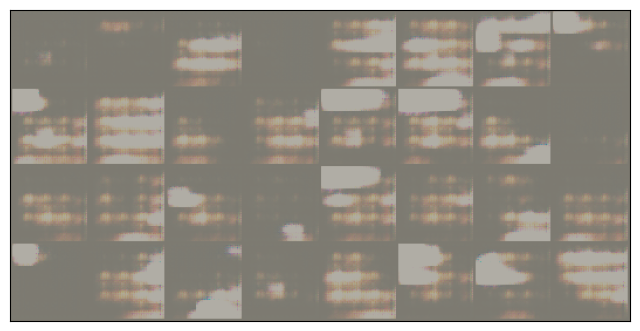

Epoch:151,   G_loss:7.890817505972726,    D_loss:0.07251908417258944
Validation - Epoch:151,   G_loss:4.692631721496582,    D_loss:0.3475806713104248
Epoch:152,   G_loss:10.694870267595563,    D_loss:0.3143548864339079
Validation - Epoch:152,   G_loss:8.321253776550293,    D_loss:0.33217665553092957
Epoch:153,   G_loss:9.478165354047503,    D_loss:0.26752627034771387
Validation - Epoch:153,   G_loss:10.182082176208496,    D_loss:0.04626109451055527
Epoch:154,   G_loss:12.434995787484306,    D_loss:0.055107938341929445
Validation - Epoch:154,   G_loss:10.145233154296875,    D_loss:0.05717822164297104
Epoch:155,   G_loss:9.467776843479701,    D_loss:0.22537964728793927
Validation - Epoch:155,   G_loss:11.889065742492676,    D_loss:0.01783926784992218
Epoch:156,   G_loss:14.363105365208217,    D_loss:0.43032884019235745
Validation - Epoch:156,   G_loss:8.494817733764648,    D_loss:0.6953328847885132
Epoch:157,   G_loss:12.231897490365165,    D_loss:0.30160134471952915
Validation - Epoch:1

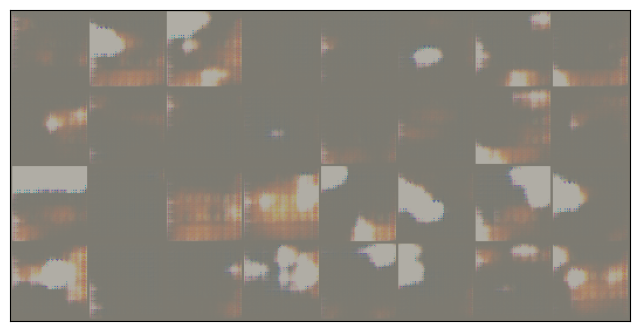

Epoch:161,   G_loss:9.801065785544258,    D_loss:0.22494405561259814
Validation - Epoch:161,   G_loss:10.719919204711914,    D_loss:0.019402656704187393
Epoch:162,   G_loss:11.160955429077148,    D_loss:0.08264887259740915
Validation - Epoch:162,   G_loss:3.7946841716766357,    D_loss:0.7997072339057922
Epoch:163,   G_loss:13.695556913103376,    D_loss:0.3154637037244226
Validation - Epoch:163,   G_loss:15.178261756896973,    D_loss:0.06592907011508942
Epoch:164,   G_loss:10.246116365705218,    D_loss:0.24747212128048496
Validation - Epoch:164,   G_loss:6.404822826385498,    D_loss:0.20354421436786652
Epoch:165,   G_loss:13.872931344168526,    D_loss:0.13423977680836938
Validation - Epoch:165,   G_loss:10.694818496704102,    D_loss:0.10711608827114105
Epoch:166,   G_loss:13.000744002205986,    D_loss:0.6867669054855858
Validation - Epoch:166,   G_loss:8.752277374267578,    D_loss:0.4628660976886749
Epoch:167,   G_loss:15.463234492710658,    D_loss:0.5437700906602133
Validation - Epoch:

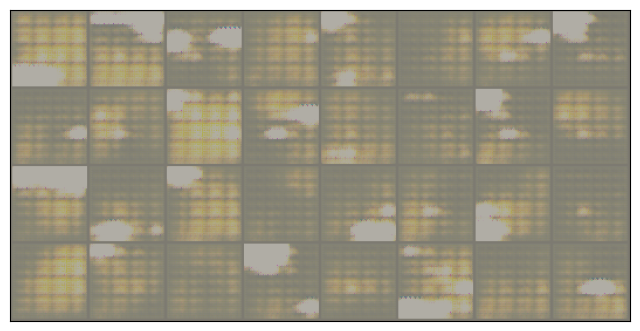

Epoch:171,   G_loss:11.913824558258057,    D_loss:0.6692398531428937
Validation - Epoch:171,   G_loss:8.171045303344727,    D_loss:0.07920348644256592
Epoch:172,   G_loss:12.534908294677734,    D_loss:0.04108499305844556
Validation - Epoch:172,   G_loss:12.956608772277832,    D_loss:0.01256747730076313
Epoch:173,   G_loss:9.218072891235352,    D_loss:0.04049827374650964
Validation - Epoch:173,   G_loss:5.971351146697998,    D_loss:0.015109597705304623
Epoch:174,   G_loss:8.513114111764091,    D_loss:1.2220839549388205
Validation - Epoch:174,   G_loss:5.134830474853516,    D_loss:0.2099841833114624
Epoch:175,   G_loss:6.813763516289847,    D_loss:0.7924978025257587
Validation - Epoch:175,   G_loss:6.1166253089904785,    D_loss:0.08657751977443695
Epoch:176,   G_loss:9.104130949292864,    D_loss:0.3279852523867573
Validation - Epoch:176,   G_loss:11.175718307495117,    D_loss:0.010439437814056873
Epoch:177,   G_loss:9.422279017312187,    D_loss:0.5064292293027393
Validation - Epoch:177, 

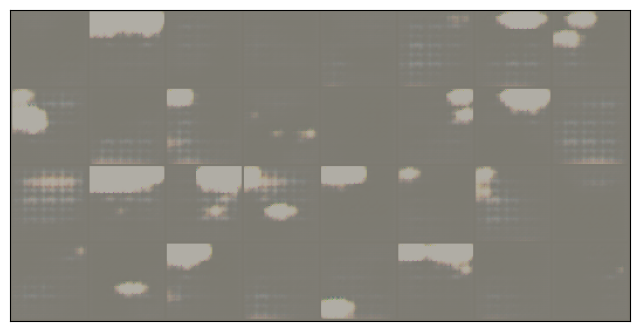

Epoch:181,   G_loss:9.293205669948033,    D_loss:0.14678835070558957
Validation - Epoch:181,   G_loss:8.0572509765625,    D_loss:0.3491094410419464
Epoch:182,   G_loss:11.536773817879814,    D_loss:0.08794898369316277
Validation - Epoch:182,   G_loss:10.959785461425781,    D_loss:0.3128606379032135
Epoch:183,   G_loss:9.96349321092878,    D_loss:0.08866494880723101
Validation - Epoch:183,   G_loss:8.154915809631348,    D_loss:0.6254081726074219
Epoch:184,   G_loss:8.057691846575056,    D_loss:0.2693594512529671
Validation - Epoch:184,   G_loss:8.881994247436523,    D_loss:0.9662797451019287
Epoch:185,   G_loss:7.606273923601423,    D_loss:0.447128312928336
Validation - Epoch:185,   G_loss:0.7730304002761841,    D_loss:2.3949217796325684
Epoch:186,   G_loss:10.830111639840263,    D_loss:1.3269091929708208
Validation - Epoch:186,   G_loss:5.982790946960449,    D_loss:0.466195285320282
Epoch:187,   G_loss:12.438873427254814,    D_loss:0.7788443832957584
Validation - Epoch:187,   G_loss:4.

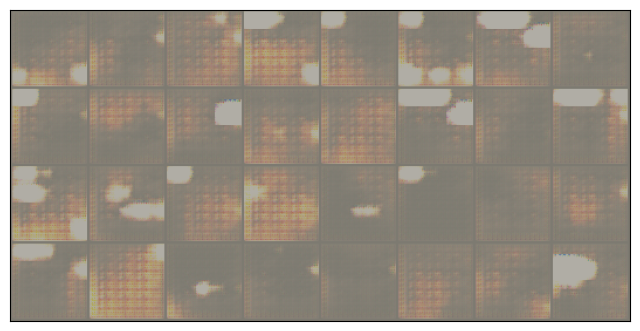

Epoch:191,   G_loss:6.983048166547503,    D_loss:0.8630800119468144
Validation - Epoch:191,   G_loss:4.254796981811523,    D_loss:0.3828558027744293
Epoch:192,   G_loss:10.680205753871373,    D_loss:0.7722099668213299
Validation - Epoch:192,   G_loss:10.512380599975586,    D_loss:0.9763375520706177
Epoch:193,   G_loss:8.380254541124616,    D_loss:0.7201284893921444
Validation - Epoch:193,   G_loss:6.9312567710876465,    D_loss:0.7743815779685974
Epoch:194,   G_loss:9.194873469216484,    D_loss:0.4486266183666885
Validation - Epoch:194,   G_loss:3.224036455154419,    D_loss:0.929595410823822
Epoch:195,   G_loss:7.77388858795166,    D_loss:0.5598488726786205
Validation - Epoch:195,   G_loss:7.777322292327881,    D_loss:0.19259747862815857
Epoch:196,   G_loss:4.27808233669826,    D_loss:0.25031837980662075
Validation - Epoch:196,   G_loss:6.2875542640686035,    D_loss:0.012620463967323303
Epoch:197,   G_loss:9.639062472752162,    D_loss:0.07682537054643035
Validation - Epoch:197,   G_loss

In [ ]:
from torch.autograd import Variable

G_losses = []
D_losses = []

best_G_loss = 0
best_D_loss = 0

real_label = 1.0
fake_label = 0.0

max_epochs = 200

for epoch in range(max_epochs):
    G_loss_run = 0.0
    D_loss_run = 0.0

    for i, data in enumerate(train_loader):
        X, _ = data  # labels of images are not very relevant
        batch_size = X.size(0)
        label = torch.full((batch_size,), real_label)
        label_f = torch.full((batch_size,), fake_label)

        z = torch.randn(batch_size, nz, 1, 1)
        fixed_noise = torch.randn(32, nz, 1, 1)

        if torch.cuda.is_available():
            X = X.cuda()
            label = label.cuda()
            z = z.cuda()
            label_f = label_f.cuda()
            fixed_noise = fixed_noise.cuda()

        ## DISCRIMINATOR TRAINING
        # train with real
        DC_D.zero_grad()

        D_real = DC_D(X)
        D_real = D_real.squeeze(1).squeeze(1).squeeze(1)
        D_real_loss = F.binary_cross_entropy(D_real, label)  # loss -(1/m)(log D(x))
        # D_real_loss.backward()

        # train with fake
        fake = DC_G(z)
        # label.fill(fake_label)
        D_fake = DC_D(fake.detach())
        D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
        D_fake_loss = F.binary_cross_entropy(D_fake, label_f)  # loss -(1/m)(log(1-D(G(z))))

        D_loss = D_real_loss + D_fake_loss

        D_loss.backward()
        D_opt.step()

        # GENERATOR training
        D_fake = DC_D(fake)

        D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
        G_loss = F.binary_cross_entropy(D_fake, label)  # loss -(1/m)(log (1-D(G(z))))

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()

    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run / (i + 1), D_loss_run / (i + 1)))

    G_losses.append(G_loss_run / (i + 1))
    D_losses.append(D_loss_run / (i + 1))

    # Validation loop
    G_val_loss = 0.0
    D_val_loss = 0.0

    for i, data in enumerate(val_loader):
        X, _ = data  # labels of images are not very relevant
        batch_size = X.size(0)
        label = torch.full((batch_size,), real_label)
        label_f = torch.full((batch_size,), fake_label)

        z = torch.randn(batch_size, nz, 1, 1)

        if torch.cuda.is_available():
            X = X.cuda()
            label = label.cuda()
            z = z.cuda()
            label_f = label_f.cuda()

        # Validation DISCRIMINATOR
        D_real = DC_D(X)
        D_real = D_real.squeeze(1).squeeze(1).squeeze(1)
        D_real_loss = F.binary_cross_entropy(D_real, label)

        fake = DC_G(z)
        D_fake = DC_D(fake.detach())
        D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
        D_fake_loss = F.binary_cross_entropy(D_fake, label_f)

        D_val_loss += (D_real_loss + D_fake_loss).item()

        # Validation GENERATOR
        D_fake = DC_D(fake)
        D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
        G_val_loss += F.binary_cross_entropy(D_fake, label).item()

    G_val_loss /= len(val_loader)
    D_val_loss /= len(val_loader)

    print('Validation - Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_val_loss, D_val_loss))

    if epoch % 10 == 0:
        with torch.no_grad():
            samples = DC_G(fixed_noise).detach()
            samples = samples.view(samples.size(0), 3, 64, 64)
            imshow_RGB(samples)

    # Save the models if they have better performance
    if G_val_loss < best_G_loss:
        best_G_loss = G_val_loss
        torch.save(DC_G.state_dict(), "best_DC_G.dth")

    if D_val_loss < best_D_loss:
        best_D_loss = D_val_loss
        torch.save(DC_D.state_dict(), "best_DC_D.dth")

# Saving the final model
print("Saving the final model state dictionary...at DC_G.dth and DC_D.dth")
torch.save(DC_G.state_dict(), "DC_G.dth")
torch.save(DC_D.state_dict(), "DC_D.dth")


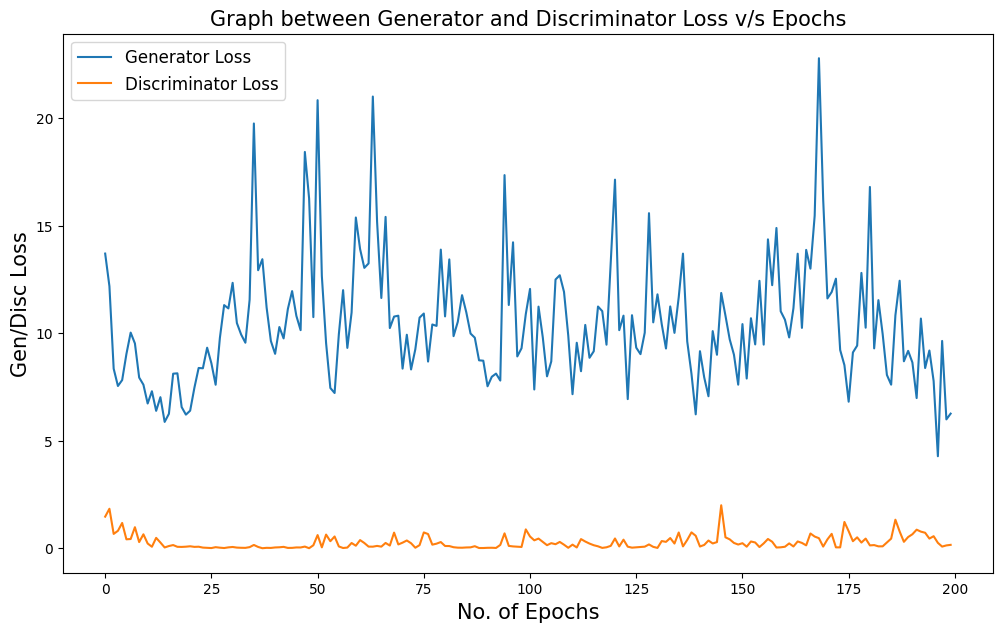

In [ ]:
#Plot losses
x_range = np.arange(0,max_epochs)
plt.figure(figsize =(12,7))
plt.plot(x_range,G_losses,label = "Generator Loss")
plt.plot(x_range,D_losses,label = "Discriminator Loss")
plt.ylabel("Gen/Disc Loss",fontsize = 15)
plt.xlabel("No. of Epochs",fontsize = 15)
plt.legend(fontsize = 12,loc = "best")
plt.title("Graph between Generator and Discriminator Loss v/s Epochs",fontsize = 15)
plt.show()


## Showing the generated images one last time

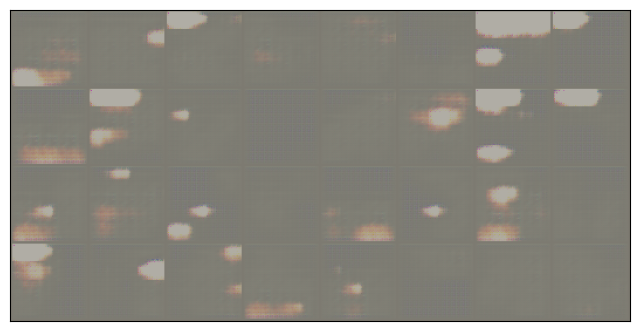

In [ ]:
fixed_noise = torch.randn(32, nz, 1, 1)
if torch.cuda.is_available():
  fixed_noise = fixed_noise.cuda()
with torch.no_grad():
    samples = DC_G(fixed_noise).detach()
    samples = samples.view(samples.size(0), 3, 64, 64)
    imshow_RGB(samples)

Q3 Comapring


Both of the images are blur but in VAW at epoch 200th we can at least we can see something like a multiple vehicle but here even after so many epoch we cant able be idetify what the image is about